# Hydrodynamic and Hydromagnetic eigenmodes of Plesio-Geostrophy Model

This notebook solves the eigenmodes of Plesio-Geostrophy (PG) model in a number of background fields. Plesio-Geostrophy model (see [Jackson and Maffei, 2020](https://doi.org/10.1098/rspa.2020.0513)) is a 2-D reduced model for 3-D MHD in rapidly rotating frame, based on near-geostrophic flows in an axisymmetric cavity.

Currently, only the axisymmetric background field is used.

In [1]:
%load_ext autoreload
%autoreload 2

import os

# Symbolics
import sympy
from sympy import *
import pg_utils.sympy_supp.vector_calculus_3d as v3d

# PG Model
from pg_utils.pg_model import *
from pg_utils.pg_model import core
from pg_utils.pg_model import base_utils as pgutils

# Numerics and plottings
import numpy as np
import matplotlib.pyplot as plt

The current demo notebook supports two alternative ways to load precomputed results:
- If the matrices have been precomputed, jump to [Precomputed matrices](#Precomputed-matrices)
- If the eigenvalue problem has already been computed, jump to [Precomputed eigenvalues](#Precomputed-eigenvalues)

## Select equations

- Use linearized equations; 
- when calculating eigenvalue problems against a zero background velocity field, one can opt to use the linearized form of induction equation in cylindrical coordinates at the boundary, instead of the $B_r$ equation

In [4]:
PRECOMPUTE_EQN = True

if PRECOMPUTE_EQN:
    with open("./out/symbolic/eqs_pg_lin.json", 'r') as fread:
        eqs_lin = base.CollectionPG.load_json(fread, parser=parse_expr)
else:
    from pg_utils.pg_model import equations as eqs
    eqs_lin = eqs.eqs_pg_lin.copy()

activated = [True if idx != 14 else False for idx in range(eqs_lin.n_fields)]

def display_equality(lhs, rhs, _filter=lambda lhs, rhs, idx: True):
    display(*(sympy.Eq(lhs_tmp, rhs[idx]) for idx, lhs_tmp in enumerate(lhs) if _filter(lhs_tmp, rhs[idx], idx)))

def display_eqs(eqs, _filter=lambda eq, idx: True):
    display(*(eq for idx, eq in enumerate(eqs) if _filter(eq, idx)))

### Choose forcing

The default is (almost) always to choose Lorentz force, since PG is mainly concerned with the expression with magnetic moments.

The following forces are possible but not yet implemented:
- viscous force / viscous diffusion: this can be readily expressed in terms of velocity field, which is known everywhere given the PG ansatz
- magnetic diffusion: according to Stefano, this is strictly NOT closed in PG variables. There might be ways to approximate them
- buoyancy force? It is mentioned in the 2020 paper, but not elaborated on. There is currently no temperature field in PG formulation
- boundary layer effects? I see Daria has the formulation of Ekman pumping in the latest notebook.

The following code chooses the Lorentz force.

In [5]:
from pg_utils.pg_model import forcing
from pg_utils.pg_model import params

# # Nondimensionalization with rotation time scale
# eqs_lin.Psi = sympy.Eq(eqs_lin.Psi.lhs, eqs_lin.Psi.rhs.subs({
#     eqs.fe_p: params.Le**2*forcing.Le_p,
#     eqs.fs_sym: params.Le**2*forcing.Ls_sym,
#     eqs.fp_sym: params.Le**2*forcing.Lp_sym,
#     eqs.fz_asym: params.Le**2*forcing.Lz_asym
# }))
# # Nondimensionalization with Alfven time scale
eqs_lin.Psi = sympy.Eq(eqs_lin.Psi.lhs, eqs_lin.Psi.rhs.subs({
    core.fe_p: forcing.Le_p,
    core.fs_sym: forcing.Ls_sym,
    core.fp_sym: forcing.Lp_sym,
    core.fz_asym: forcing.Lz_asym,
    core.pgvar_ptb.Psi: core.pgvar_ptb.Psi/params.Le
}).doit())
eqs_lin.Psi

Eq(s*Derivative(\psi(s, \phi, t), (s, 2), t)/H(s) - s*Derivative(H(s), s)*Derivative(\psi(s, \phi, t), s, t)/H(s)**2 + Derivative(\psi(s, \phi, t), s, t)/H(s) - Derivative(H(s), s)*Derivative(\psi(s, \phi, t), (\phi, 2), t)/(2*H(s)**2) + Derivative(\psi(s, \phi, t), (\phi, 2), t)/(s*H(s)), s*L_{e\phi}(s, \phi, t)*Derivative(H(s), s)/H(s) - s*Derivative(\overline{L_\phi}(s, \phi, t), s)/(2*H(s)) - \overline{L_\phi}(s, \phi, t)/(2*H(s)) + Derivative(H(s), s)*Derivative(\widetilde{L_z}(s, \phi, t), \phi)/(2*H(s)) + Derivative(\overline{L_s}(s, \phi, t), \phi)/(2*H(s)) - 2*Derivative(H(s), s)*Derivative(\psi(s, \phi, t), \phi)/(\mathrm{Le}*H(s)**2))

## Background field

### Background velocity field

In [6]:
U0_val = v3d.Vector3D((S.Zero, S.Zero, S.Zero), core.cyl)
display_equality(core.U0_vec, U0_val)

Eq(U_s^0(s, \phi, z), 0)

Eq(U_\phi^0(s, \phi, z), 0)

Eq(U_z^0(s, \phi, z), 0)

### Background magnetic field

Case 1. Malkus background field

In [7]:
B0_val = v3d.Vector3D((S.Zero, s, S.Zero), core.cyl)
display_equality(core.B0_vec, B0_val)

Eq(B_s^0(s, \phi, z), 0)

Eq(B_\phi^0(s, \phi, z), s)

Eq(B_z^0(s, \phi, z), 0)

Case 2. toroidal quadrupolar field

In [ ]:
B0_val = v3d.Vector3D((S.Zero, s*(S.One - s**2 - z**2), S.Zero), core.cyl)
display_eqs(core.B0_vec, B0_val)

### Assemble the PG backgrounds

In the following snippet, only nontrivial fields are printed.

In [8]:
pgvar_bg_val = pgutils.assemble_background(B0=B0_val)
display_equality(core.pgvar_bg, pgvar_bg_val, _filter=lambda lhs, rhs, idx: False if rhs.equals(sympy.S.Zero) else True)

Eq(\overline{M_{\phi\phi}}^0(s, \phi), 2*s**2*sqrt(1 - s**2))

Eq(\widetilde{zM_{\phi\phi}}^0(s, \phi), s**2*(1 - s**2))

Eq(B_{e\phi}^0(s, \phi), s)

Eq(B_\phi^{0+}(s, \phi), s)

Eq(B_\phi^{0-}(s, \phi), s)

### Visualization

#### magnetic field

In [14]:
import numpy as np
import matplotlib.pyplot as plt

B_fun = [sympy.lambdify((s, p, z), component, modules=["scipy", "numpy"]) for component in B0_val]

For 1-D axisymmetric case: radial profiles

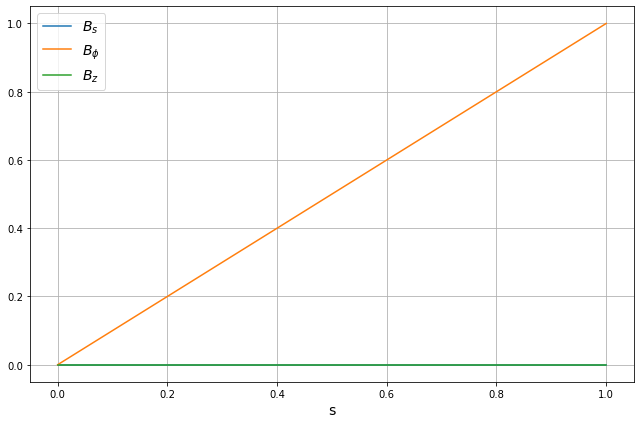

In [10]:
s_array = np.linspace(0, 1, num=100)

fig, ax = plt.subplots(figsize=(9, 6))
for i_comp, component in enumerate(B_fun):
    ax.plot(s_array, component(s_array, 0, 0)*np.ones(s_array.shape), label="$B_{:s}$".format(core.cyl.coords[i_comp].name))

ax.set_xlabel('s', fontsize=14)
ax.grid(True)
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()

For non-axisymmetric case: equatorial and meridional cross-sections

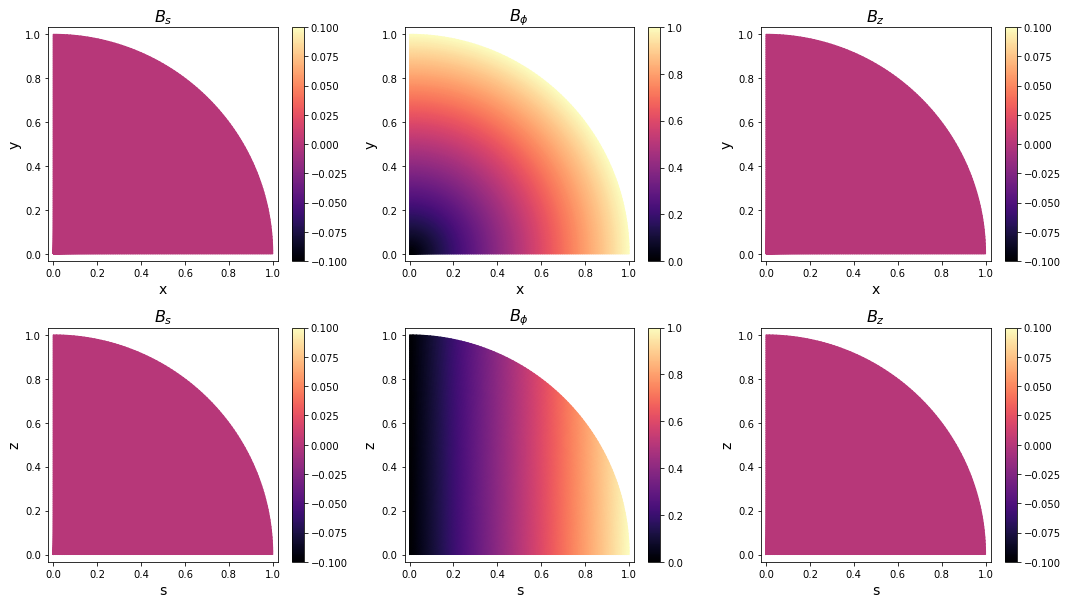

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8.5))

s_array = np.linspace(0, 1, num=100)
p_array = np.linspace(0, np.pi/2, num=100)
S_mesh, P_mesh = np.meshgrid(s_array, p_array)
X_mesh, Y_mesh = S_mesh*np.cos(P_mesh), S_mesh*np.sin(P_mesh)

for i_comp, component in enumerate(B_fun):
    ax = axes[0, i_comp]
    cm = ax.pcolormesh(X_mesh, Y_mesh, component(S_mesh, P_mesh, np.zeros(S_mesh.shape))*np.ones(S_mesh.shape), shading="gouraud", cmap="magma")
    ax.axis("equal")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)
    ax.set_title("$B_{:s}$".format(core.cyl.coords[i_comp].name), fontsize=16)
    plt.colorbar(cm, ax=ax)

p_cut = np.pi/2
r_array = np.linspace(0, 1, num=100)
t_array = np.linspace(0, np.pi/2, num=100)
R_mesh, T_mesh = np.meshgrid(r_array, t_array)
S_mesh, Z_mesh = R_mesh*np.sin(T_mesh), R_mesh*np.cos(T_mesh)

for i_comp, component in enumerate(B_fun):
    ax = axes[1, i_comp]
    cm = ax.pcolormesh(S_mesh, Z_mesh, component(S_mesh, p_cut*np.ones(S_mesh.shape), Z_mesh)*np.ones(S_mesh.shape), shading="gouraud", cmap="magma")
    ax.axis("equal")
    ax.set_xlabel("s", fontsize=14)
    ax.set_ylabel("z", fontsize=14)
    ax.set_title("$B_{:s}$".format(core.cyl.coords[i_comp].name), fontsize=16)
    plt.colorbar(cm, ax=ax)

plt.tight_layout()
plt.show()

#### magnetic moments

In [12]:
moments_fun = [sympy.lambdify((s, p, z), component, modules=["scipy", "numpy"]) for component in pgvar_bg_val.subset_moments()]

For axisymmetric fields: radial profile

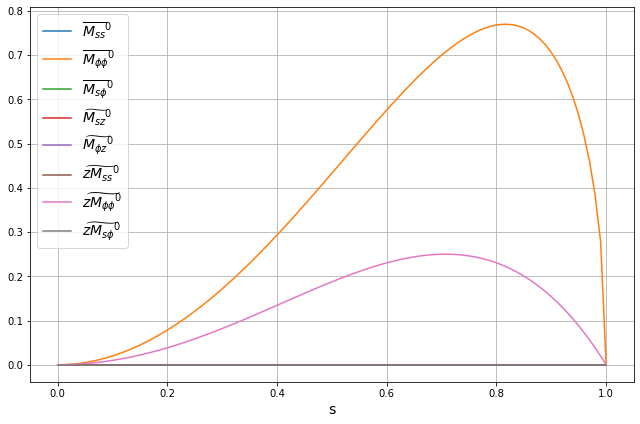

In [13]:
s_array = np.linspace(0, 1, num=100)

fig, ax = plt.subplots(figsize=(9, 6))
for i_comp, component in enumerate(moments_fun):
    ax.plot(s_array, component(s_array, 0, 0)*np.ones(s_array.shape), label="${:s}$".format(core.pgvar_bg.subset_moments()[i_comp].name))

ax.set_xlabel('s', fontsize=14)
ax.grid(True)
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()

For non-axisymmetric case: equatorial cross-sections

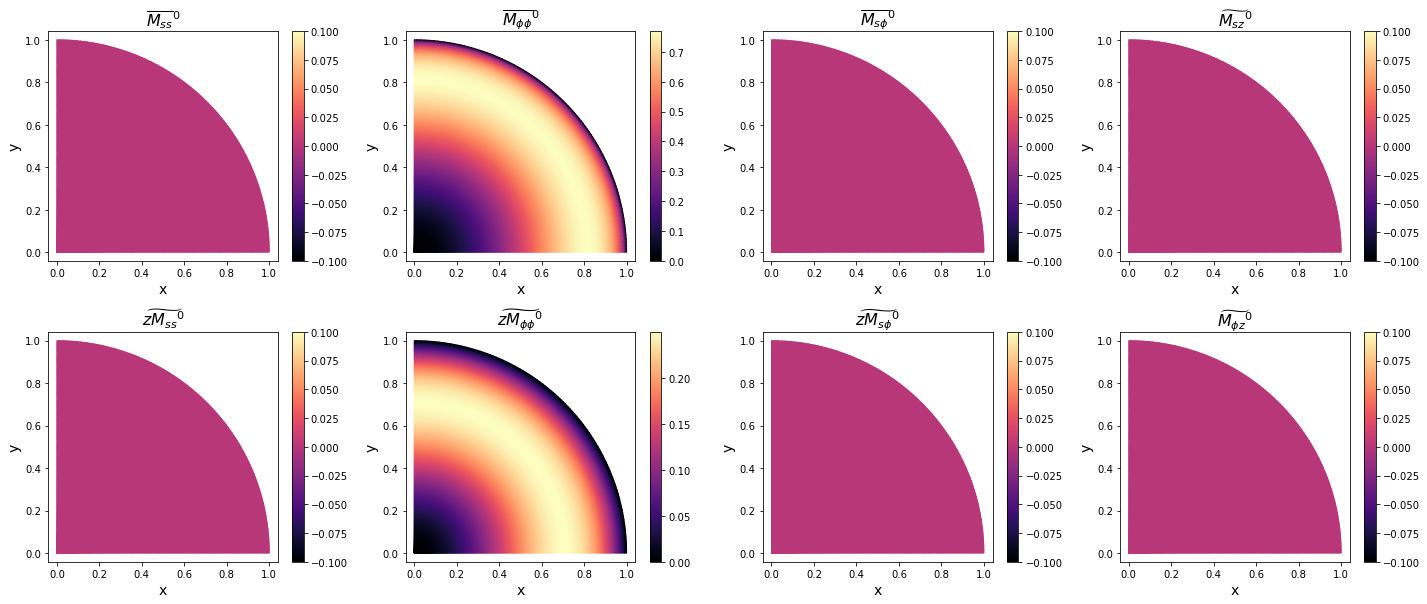

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8.5))

axis_arrangement = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (1, 0), (1, 1), (1, 2)]

s_array = np.linspace(0, 1, num=100)
p_array = np.linspace(0, np.pi/2, num=100)
S_mesh, P_mesh = np.meshgrid(s_array, p_array)
X_mesh, Y_mesh = S_mesh*np.cos(P_mesh), S_mesh*np.sin(P_mesh)

for i_comp, component in enumerate(moments_fun):
    ax = axes[axis_arrangement[i_comp][0], axis_arrangement[i_comp][1]]
    cm = ax.pcolormesh(X_mesh, Y_mesh, component(S_mesh, P_mesh, np.zeros(S_mesh.shape))*np.ones(S_mesh.shape), shading="gouraud", cmap="magma")
    ax.axis("equal")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)
    ax.set_title("${:s}$".format(core.pgvar_bg.subset_moments()[i_comp].name), fontsize=16)
    plt.colorbar(cm, ax=ax)

plt.tight_layout()
plt.show()

### Applying background field

In [9]:
# Explicit form of Lorentz force
Lorentz_explicit = {forcing.Le_p: forcing.Le_p_lin, forcing.Ls_sym: forcing.Ls_sym_lin, 
                    forcing.Lp_sym: forcing.Lp_sym_lin, forcing.Lz_asym: forcing.Lz_asym_lin}

# Substitution of background field
bg_field_sub = {u_comp: U0_val[i_comp] for i_comp, u_comp in enumerate(core.U0_vec)}
bg_field_sub.update({b_comp: B0_val[i_comp] for i_comp, b_comp in enumerate(core.B0_vec)})
bg_field_sub.update({pgvar_bg_comp: pgvar_bg_val[i_comp] for i_comp, pgvar_bg_comp in enumerate(core.pgvar_bg)})

# def apply_bg(field_name, eq):
#     if field_name == "Psi":
#         new_lhs = eq.lhs.subs(bg_field_sub).subs({H: H_s}).doit().subs({H_s: H}).expand()
#         new_rhs = eq.rhs.subs(Lorentz_explicit).subs(bg_field_sub).subs({H: H_s}).doit().subs({H_s: H}).expand()
#     else:
#         new_lhs = eq.lhs.subs(bg_field_sub).subs({H: H_s}).doit().simplify().expand().subs({H_s: H})
#         new_rhs = eq.rhs.subs(bg_field_sub).subs({H: H_s}).doit().simplify().expand().subs({H_s: H})
#     return sympy.Eq(new_lhs, new_rhs)

def apply_bg(field_name, eq):
    if field_name == "Psi":
        new_lhs = eq.lhs.subs(bg_field_sub).subs({H: H_s}).doit().subs({H_s: H}).expand()
        new_rhs = eq.rhs.subs(Lorentz_explicit).subs(bg_field_sub).subs({H: H_s}).doit().subs({H_s: H}).expand()
    else:
        new_lhs = eq.lhs.subs(bg_field_sub).subs({H: H_s}).doit().simplify().subs({H_s: H}).expand()
        new_rhs = eq.rhs.subs(bg_field_sub).subs({H: H_s}).doit().simplify().subs({H_s: H}).expand()
    return sympy.Eq(new_lhs, new_rhs)

eqs_lin_bg = eqs_lin.apply(apply_bg, inplace=False, metadata=True)

# take limit at specific point for specific points
eqs_tmp = eqs_lin_bg.subset_B_equator()
for i_eq, eq in enumerate(eqs_tmp):
    eqs_tmp[i_eq] = sympy.Eq(eqs_tmp[i_eq].lhs, eqs_tmp[i_eq].rhs.subs({z: sympy.S.Zero}))

eqs_tmp = eqs_lin_bg.subset_B_bound_cyl()
for i_eq, eq in enumerate(eqs_tmp):
    if eqs_tmp._sub_names[i_eq][-1] == 'p':
        eqs_tmp[i_eq] = sympy.Eq(eqs_tmp[i_eq].lhs, eqs_tmp[i_eq].rhs.subs({z: +H}).doit().simplify().expand().subs({H_s: H, 1-s**2: H**2}))
    elif eqs_tmp._sub_names[i_eq][-1] == 'm':
        eqs_tmp[i_eq] = sympy.Eq(eqs_tmp[i_eq].lhs, eqs_tmp[i_eq].rhs.subs({z: -H}).doit().simplify().expand().subs({H_s: H, 1-s**2: H**2}))

display_eqs(eqs_lin_bg, _filter=lambda eq, idx: activated[idx])

Eq(s**2*Derivative(\psi(s, \phi, t), s, t)/H(s)**3 + s*Derivative(\psi(s, \phi, t), (s, 2), t)/H(s) + s*Derivative(\psi(s, \phi, t), (\phi, 2), t)/(2*H(s)**3) + Derivative(\psi(s, \phi, t), s, t)/H(s) + Derivative(\psi(s, \phi, t), (\phi, 2), t)/(s*H(s)), -s**4*b_s^+(s, \phi, t)/(2*H(s)**4) - s**4*b_s^-(s, \phi, t)/(2*H(s)**4) - s**3*Derivative(b_s^+(s, \phi, t), s)/(2*H(s)**2) - s**3*Derivative(b_s^-(s, \phi, t), s)/(2*H(s)**2) - s**2*Derivative(b_z^+(s, \phi, t), s)/(2*H(s)) + s**2*Derivative(b_z^-(s, \phi, t), s)/(2*H(s)) - 3*s**2*b_s^+(s, \phi, t)/(2*H(s)**2) - 3*s**2*b_s^-(s, \phi, t)/(2*H(s)**2) - 2*s**2*b_{es}(s, \phi, t)/H(s)**2 - s**2*Derivative(b_{e\phi}(s, \phi, t), \phi)/H(s)**2 - s*b_z^+(s, \phi, t)/H(s) + s*b_z^-(s, \phi, t)/H(s) - s*Derivative(\overline{m_{s\phi}}(s, \phi, t), (s, 2))/(2*H(s)) - s*Derivative(\widetilde{m_{sz}}(s, \phi, t), \phi, s)/(2*H(s)**2) - 3*Derivative(\overline{m_{s\phi}}(s, \phi, t), s)/(2*H(s)) - Derivative(\overline{m_{\phi\phi}}(s, \phi, t), \

Eq(Derivative(\overline{m_{ss}}(s, \phi, t), t), 0)

Eq(Derivative(\overline{m_{\phi\phi}}(s, \phi, t), t), -4*s*Derivative(\psi(s, \phi, t), \phi, s))

Eq(Derivative(\overline{m_{s\phi}}(s, \phi, t), t), 2*Derivative(\psi(s, \phi, t), (\phi, 2)))

Eq(Derivative(\widetilde{m_{sz}}(s, \phi, t), t), 0)

Eq(Derivative(\widetilde{m_{\phi z}}(s, \phi, t), t), -s*Derivative(\psi(s, \phi, t), (\phi, 2))/H(s))

Eq(Derivative(\widetilde{zm_{ss}}(s, \phi, t), t), 0)

Eq(Derivative(\widetilde{zm_{\phi\phi}}(s, \phi, t), t), -2*s*H(s)*Derivative(\psi(s, \phi, t), \phi, s))

Eq(Derivative(\widetilde{zm_{s\phi}}(s, \phi, t), t), H(s)*Derivative(\psi(s, \phi, t), (\phi, 2)))

Eq(Derivative(b_{es}(s, \phi, t), t), Derivative(\psi(s, \phi, t), (\phi, 2))/(s*H(s)))

Eq(Derivative(b_{e\phi}(s, \phi, t), t), -Derivative(\psi(s, \phi, t), \phi, s)/H(s))

Eq(Derivative(b_{ez}(s, \phi, t), t), 0)

Eq(Derivative(b_{es, z}(s, \phi, t), t), 0)

Eq(Derivative(b_{e\phi, z}(s, \phi, t), t), 0)

Eq(Derivative(b_s^+(s, \phi, t), t), Derivative(\psi(s, \phi, t), (\phi, 2))/(s*H(s)))

Eq(Derivative(b_\phi^+(s, \phi, t), t), -Derivative(\psi(s, \phi, t), \phi, s)/H(s))

Eq(Derivative(b_z^+(s, \phi, t), t), -Derivative(\psi(s, \phi, t), (\phi, 2))/H(s)**2)

Eq(Derivative(b_s^-(s, \phi, t), t), Derivative(\psi(s, \phi, t), (\phi, 2))/(s*H(s)))

Eq(Derivative(b_\phi^-(s, \phi, t), t), -Derivative(\psi(s, \phi, t), \phi, s)/H(s))

Eq(Derivative(b_z^-(s, \phi, t), t), Derivative(\psi(s, \phi, t), (\phi, 2))/H(s)**2)

For actually solving the set of equations, never include the boundary equations in cylindrical coordinates in the algebraic system. These
- cannot be time stepped anyway;
- should either be ignored (like Daria did in the notebook for Malkus case, and other cases where the boundary terms do vanish) or incorporated (because they are functions of $\psi$ solely)

The following code block extracts the first 14 equations of PG (the non-boundary equations), and store the boundary equations separately.

In [10]:
solve_idx = np.full(21, False)
solve_idx[:14] = True

eqs_solve = eqs_lin_bg.generate_collection(solve_idx)
eqs_bound = eqs_lin_bg.generate_collection(~solve_idx)

### Reduced form

When the eigenvalue problem in PG formulation:
- does not involve magnetic diffusion
- has zero background velocity
then the system which originally involves 15+ variables can be reduced into a first-order system with only two variables (in the sense of dynamical variables).
The two relevant dynamical variables are the stream function $\psi$ and the Lorentz force term, which is denoted as $f_L$ below.
For details, please refer to the [formulation document](./formulations/PG_Assim.pdf).

Ideally, the reduction of original equations to this form should be done at the time when the forces are assembled.

When the forces have already been combined in the system, then extracting different terms can only be done case by case.
However, the routine below applies to any eigenvalue problem that only involves Lorentz force and Coriolis force.
Eigenvalue problems which involves viscous diffusion, convection term etc. might need extra work.

#### First-order dynamical system

1. Extracting forces corresponding to Lorentz force

In [9]:
forcing_terms = eqs_lin_bg.Psi.rhs.args
f_psi = sympy.S.Zero
f_lorentz = sympy.S.Zero

for f_term in forcing_terms:
    if pgutils.fields_in_term(f_term, core.pgvar_ptb)[0] == core.pgvar_ptb.Psi:
        f_psi += f_term
    else:
        f_lorentz += f_term

2. The first equation (vorticity eq) now has right hand side of itself $\psi$ and Lorentz force
3. The second equation is the evolution equation for Lorentz force, as a function of $\psi$

In [10]:
f_lorentz_field = sympy.Function(r"f_L")(s, p, t)
eq_psi_reduced = sympy.Eq(eqs_lin_bg.Psi.lhs, f_psi + f_lorentz_field)

lorentz_subs = {eqs_lin_bg[i_f].lhs: eqs_lin_bg[i_f].rhs for i_f in range(1, eqs_lin_bg.n_fields) if activated[i_f]}
f_lorentz_var = diff(f_lorentz, t).doit().subs(lorentz_subs).doit()
f_lorentz_terms = [f_term.subs({H: H_s}).doit().subs({H_s: H}).expand() for f_term in f_lorentz_var.args]
f_lorentz_var = sympy.Add(*f_lorentz_terms)
eq_lorentz = sympy.Eq(diff(f_lorentz_field, t), f_lorentz_var)

display(eq_psi_reduced)
display(eq_lorentz)

Eq(s**2*Derivative(\psi(s, \phi, t), s, t)/H(s)**3 + s*Derivative(\psi(s, \phi, t), (s, 2), t)/H(s) + s*Derivative(\psi(s, \phi, t), (\phi, 2), t)/(2*H(s)**3) + Derivative(\psi(s, \phi, t), s, t)/H(s) + Derivative(\psi(s, \phi, t), (\phi, 2), t)/(s*H(s)), 2*s*Derivative(\psi(s, \phi, t), \phi)/H(s)**3 + f_L(s, \phi, t))

Eq(Derivative(f_L(s, \phi, t), t), \mathrm{Le}**2*s**2*Derivative(\psi(s, \phi, t), (\phi, 2), s)/H(s)**3 + \mathrm{Le}**2*s*Derivative(\psi(s, \phi, t), (\phi, 2), (s, 2))/H(s) - 2*\mathrm{Le}**2*s*Derivative(\psi(s, \phi, t), (\phi, 2))/H(s)**3 + \mathrm{Le}**2*s*Derivative(\psi(s, \phi, t), (\phi, 4))/(2*H(s)**3) + \mathrm{Le}**2*Derivative(\psi(s, \phi, t), (\phi, 2), s)/H(s) + \mathrm{Le}**2*Derivative(\psi(s, \phi, t), (\phi, 4))/(s*H(s)))

#### Second-order form

The system can be further reduced a single second-order equation of $\psi$. 

However, tthe second-order form is not a standard form of the dynamical system, and may only be relevant for analytical development.

In [11]:
eq_2order = sympy.Eq(diff(eq_psi_reduced.lhs, t), diff(eq_psi_reduced.rhs, t).subs({eq_lorentz.lhs: eq_lorentz.rhs}).doit().expand())
eq_2order

Eq(s**2*Derivative(\psi(s, \phi, t), s, (t, 2))/H(s)**3 + s*Derivative(\psi(s, \phi, t), (s, 2), (t, 2))/H(s) + s*Derivative(\psi(s, \phi, t), (\phi, 2), (t, 2))/(2*H(s)**3) + Derivative(\psi(s, \phi, t), s, (t, 2))/H(s) + Derivative(\psi(s, \phi, t), (\phi, 2), (t, 2))/(s*H(s)), \mathrm{Le}**2*s**2*Derivative(\psi(s, \phi, t), (\phi, 2), s)/H(s)**3 + \mathrm{Le}**2*s*Derivative(\psi(s, \phi, t), (\phi, 2), (s, 2))/H(s) - 2*\mathrm{Le}**2*s*Derivative(\psi(s, \phi, t), (\phi, 2))/H(s)**3 + \mathrm{Le}**2*s*Derivative(\psi(s, \phi, t), (\phi, 4))/(2*H(s)**3) + \mathrm{Le}**2*Derivative(\psi(s, \phi, t), (\phi, 2), s)/H(s) + \mathrm{Le}**2*Derivative(\psi(s, \phi, t), (\phi, 4))/(s*H(s)) + 2*s*Derivative(\psi(s, \phi, t), \phi, t)/H(s)**3)

## Expanding the system

This section expands the PG fields into basis functions and reduces the system to linear systems.
This is the bridge between symbolic evaluation and numerical computations.

In the first part we shall only work with full system (14 equations)

### Recipe setup

The standard way to set up the expansion recipe is now to use a configuration file.
For an example, see `cfg_expand`.

In [11]:
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import cfg_expand as cfg
from pg_utils.pg_model.expansion import omega, n, m, xi, n_test, n_trial

eqs_solve = xpd.SystemEquations(eqs_solve._field_names, cfg.recipe, 
    **{fname: eqs_solve[fname] for fname in eqs_solve._field_names})

### Reduce to linear system

In [12]:
eqs_solve.to_fourier_domain(inplace=True).to_radial(inplace=True).to_inner_product(factor_lhs=sympy.I*omega, inplace=True)
display_eqs(eqs_solve)

Eq(I*C_{\Psi}^{mn}*\omega*InnerProduct1D(\Phi_{\Psi}^{mn'}(s), -m**2*s*\Phi_{\Psi}^{mn}(s)/(2*H(s)**3) - m**2*\Phi_{\Psi}^{mn}(s)/(s*H(s)) + s**2*Derivative(\Phi_{\Psi}^{mn}(s), s)/H(s)**3 + s*Derivative(\Phi_{\Psi}^{mn}(s), (s, 2))/H(s) + Derivative(\Phi_{\Psi}^{mn}(s), s)/H(s), 1, s, 0, 1), C_{\Psi}^{mn}*InnerProduct1D(\Phi_{\Psi}^{mn'}(s), 2*I*m*s*\Phi_{\Psi}^{mn}(s)/(\mathrm{Le}*H(s)**3), 1, s, 0, 1) + C_{\phi z}^{mn}*InnerProduct1D(\Phi_{\Psi}^{mn'}(s), m**2*\Phi_{\phi z}^{mn}(s)/(2*H(s)**2), 1, s, 0, 1) + C_{\phi\phi}^{mn}*InnerProduct1D(\Phi_{\Psi}^{mn'}(s), -I*m*Derivative(\Phi_{\phi\phi}^{mn}(s), s)/(2*H(s)) - I*m*\Phi_{\phi\phi}^{mn}(s)/(2*s*H(s)), 1, s, 0, 1) + C_{e\phi}^{mn}*InnerProduct1D(\Phi_{\Psi}^{mn'}(s), -I*m*s**2*\Phi_{e\phi}^{mn}(s)/H(s)**2, 1, s, 0, 1) + C_{es}^{mn}*InnerProduct1D(\Phi_{\Psi}^{mn'}(s), m*s**2*\Phi_{es}^{mn}(s)*sign(m)/H(s)**2 - 2*s**2*\Phi_{es}^{mn}(s)/H(s)**2, 1, s, 0, 1) + C_{s\phi}^{mn}*InnerProduct1D(\Phi_{\Psi}^{mn'}(s), -m**2*\Phi_{s\phi}^{m

Eq(I*C_{ss}^{mn}*\omega*InnerProduct1D(\Phi_{ss}^{mn'}(s), \Phi_{ss}^{mn}(s), 1, s, 0, 1), 0)

Eq(I*C_{\phi\phi}^{mn}*\omega*InnerProduct1D(\Phi_{\phi\phi}^{mn'}(s), \Phi_{\phi\phi}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}*InnerProduct1D(\Phi_{\phi\phi}^{mn'}(s), -4*I*m*s*Derivative(\Phi_{\Psi}^{mn}(s), s), 1, s, 0, 1))

Eq(I*C_{s\phi}^{mn}*\omega*InnerProduct1D(\Phi_{s\phi}^{mn'}(s), \Phi_{s\phi}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}*InnerProduct1D(\Phi_{s\phi}^{mn'}(s), -2*m**2*\Phi_{\Psi}^{mn}(s), 1, s, 0, 1))

Eq(I*C_{sz}^{mn}*\omega*InnerProduct1D(\Phi_{sz}^{mn'}(s), \Phi_{sz}^{mn}(s), 1, s, 0, 1), 0)

Eq(I*C_{\phi z}^{mn}*\omega*InnerProduct1D(\Phi_{\phi z}^{mn'}(s), \Phi_{\phi z}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}*InnerProduct1D(\Phi_{\phi z}^{mn'}(s), m**2*s*\Phi_{\Psi}^{mn}(s)/H(s), 1, s, 0, 1))

Eq(I*C_{zss}^{mn}*\omega*InnerProduct1D(\Phi_{zss}^{mn'}(s), \Phi_{zss}^{mn}(s), 1, s, 0, 1), 0)

Eq(I*C_{z\phi\phi}^{mn}*\omega*InnerProduct1D(\Phi_{z\phi\phi}^{mn'}(s), \Phi_{z\phi\phi}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}*InnerProduct1D(\Phi_{z\phi\phi}^{mn'}(s), -2*I*m*s*H(s)*Derivative(\Phi_{\Psi}^{mn}(s), s), 1, s, 0, 1))

Eq(I*C_{zs\phi}^{mn}*\omega*InnerProduct1D(\Phi_{zs\phi}^{mn'}(s), \Phi_{zs\phi}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}*InnerProduct1D(\Phi_{zs\phi}^{mn'}(s), -m**2*H(s)*\Phi_{\Psi}^{mn}(s), 1, s, 0, 1))

Eq(I*C_{es}^{mn}*\omega*InnerProduct1D(\Phi_{es}^{mn'}(s), \Phi_{es}^{mn}(s), 1, s, 0, 1), C_{\Psi}^{mn}*InnerProduct1D(\Phi_{es}^{mn'}(s), -m**2*\Phi_{\Psi}^{mn}(s)/(s*H(s)), 1, s, 0, 1))

Eq(I*C_{e\phi}^{mn}*\omega*InnerProduct1D(\Phi_{e\phi}^{mn'}(s), \Phi_{e\phi}^{mn}(s), 1, s, 0, 1) + I*C_{es}^{mn}*\omega*InnerProduct1D(\Phi_{e\phi}^{mn'}(s), I*\Phi_{es}^{mn}(s)*sign(m), 1, s, 0, 1), C_{\Psi}^{mn}*InnerProduct1D(\Phi_{e\phi}^{mn'}(s), -I*m*Derivative(\Phi_{\Psi}^{mn}(s), s)/H(s), 1, s, 0, 1))

Eq(I*C_{ez}^{mn}*\omega*InnerProduct1D(\Phi_{ez}^{mn'}(s), \Phi_{ez}^{mn}(s), 1, s, 0, 1), 0)

Eq(I*C_{es,z}^{mn}*\omega*InnerProduct1D(\Phi_{es,z}^{mn'}(s), \Phi_{es,z}^{mn}(s), 1, s, 0, 1), 0)

Eq(I*C_{e\phi,z}^{mn}*\omega*InnerProduct1D(\Phi_{e\phi,z}^{mn'}(s), \Phi_{e\phi,z}^{mn}(s), 1, s, 0, 1), 0)

### Collect matrix elements

The linear system in the end concerns two matrices: the mass matrix $\mathbf{M}$, and the stiffness matrix $\mathbf{K}$, both of which are formed from computing the inner products between the expansion of the expressions in trial functions and the test functions.

So what are the matrix elements? This can be easily retrieved using the `collect_matrices` method.

In [13]:
M_expr, K_expr = eqs_solve.collect_matrices(factor_lhs=sympy.I*omega)

map_trial = base.map_collection(cfg.bases_s, cfg.bases_s_expression.subs({n: n_trial}))
map_test = base.map_collection(cfg.test_s, cfg.bases_s_expression.subs({n: n_test}))
fnames = base.CollectionPG.pg_field_names[:14]
cnames = cfg.recipe.rad_xpd.coeffs._field_names

In [14]:
with open("./out/symbolic/Malkus/Matrix_M.json", 'x') as fwrite:
    M_expr.save_json(fwrite)
with open("./out/symbolic/Malkus/Matrix_K.json", 'x') as fwrite:
    K_expr.save_json(fwrite)

Which elements are activated? A sparsity plot can be generated to signify which inner products are nontrivial.

In [26]:
with open("./out/symbolic/Malkus/Matrix_expr_M.json", 'r') as fread:
    M_cmp = xpd.SystemMatrix.load_json(fread)
with open("./out/symbolic/Malkus/Matrix_expr_K.json", 'r') as fread:
    K_cmp = xpd.SystemMatrix.load_json(fread)

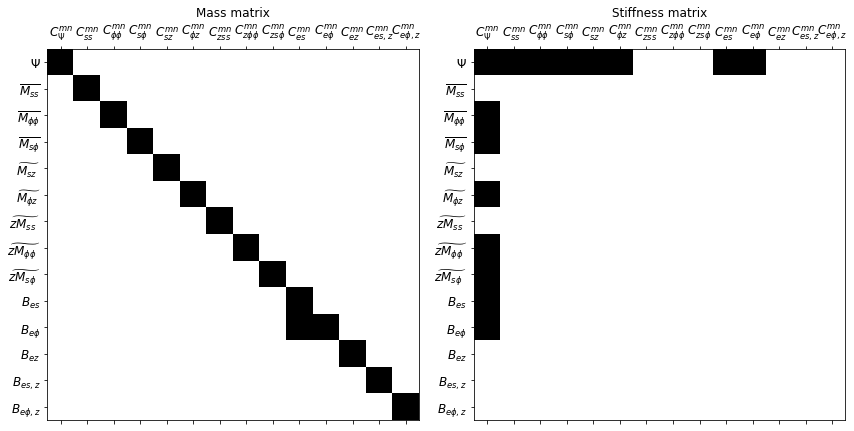

In [27]:
M_shape = M_cmp.block_sparsity()
K_shape = K_cmp.block_sparsity()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax = axes[0]
ax.spy(M_shape)
ax.set_xticks(np.arange(cfg.coeff_s.n_fields))
ax.set_xticklabels([r'$%s$' % cfg.coeff_s[fname].name for fname in cfg.coeff_s._field_names], fontsize=12)
ax.set_yticks(np.arange(eqs_solve.n_fields))
ax.set_yticklabels([r'$%s$' % core.pgvar[fname].name for fname in eqs_solve._field_names], fontsize=12)
ax.set_title("Mass matrix", fontsize=12)

ax = axes[1]
ax.spy(K_shape)
ax.set_xticks(np.arange(cfg.coeff_s.n_fields))
ax.set_xticklabels([r'$%s$' % cfg.coeff_s[fname].name for fname in cfg.coeff_s._field_names], fontsize=12)
ax.set_yticks(np.arange(eqs_solve.n_fields))
ax.set_yticklabels([r'$%s$' % core.pgvar[fname].name for fname in eqs_solve._field_names], fontsize=12)
ax.set_title("Stiffness matrix", fontsize=12)

plt.tight_layout()
# plt.savefig("./out/imgs/sparsity__recipe_Daria_quad_Malkus.pdf", format="pdf", bbox_inches="tight")
plt.show()

A few comments:
- Given some configuration and expansion, mass matrix $\mathbf{M}$ is independent of the background field in eigenvalue problems, and would remain constant throughout the time stepping;
- $\mathbf{M}$ is block-diagonal; the size of the block is related to the coupling.
- The stiffness matrix $\mathbf{K}$ is dependent on the configuration, expansion, as well as the background field.
- For any eigenvalue problem with $\mathbf{U}_0 = 0$, $\mathbf{K}$ will be trivial except for the first row block and the first column block.

We can inspect the contents of each of the matrix elements.

Formal expression (with placeholders):

In [13]:
ele_tmp = M_expr["Msp", "Msp"]
ele_tmp

InnerProduct1D(\Phi_{s\phi}^{mn'}(s), \Phi_{s\phi}^{mn}(s), 1, s, 0, 1)

Explicit expressions for the trial and test functions:

In [17]:
ele_tmp = ele_tmp.subs(map_trial).subs(map_test).subs({H_s: H, H_s**2: H**2}).expand().subs({H: H_s})
ele_tmp

InnerProduct1D(s**Abs(Abs(m) - 2)*(1 - s**2)*jacobi(\ell', 2, Abs(Abs(m) - 2) - 1/2, 2*s**2 - 1), s**Abs(Abs(m) - 2)*(1 - s**2)*jacobi(\ell, 2, Abs(Abs(m) - 2) - 1/2, 2*s**2 - 1), 1, s, 0, 1)

 Standard inner product ($\xi \in [-1, 1]$) (only run if element nontrivial)

In [18]:
ele_tmp.change_variable(xi, xpd.s_xi, xpd.xi_s, jac_positive=True, merge=True, simplify=True)

InnerProduct1D(2**(-Abs(Abs(m) - 2)/2 - 1)*(1 - \xi)*(\xi + 1)**(Abs(Abs(m) - 2)/2)*jacobi(\ell', 2, Abs(Abs(m) - 2) - 1/2, \xi), -sqrt(2)*(sqrt(2)/2)**Abs(Abs(m) - 2)*(\xi - 1)*(\xi + 1)**(Abs(Abs(m) - 2)/2 - 1/2)*jacobi(\ell, 2, Abs(Abs(m) - 2) - 1/2, \xi)/8, 1, \xi, -1, 1)

## Assembling matrices

For axisymmetric background fields, different azimuthal wavenumbers $m$ are decoupled.

The following section assembles the mass and stiffness matrices for a specific azimuthal wavenumber.

First, we need to define physical parameters. These include azimuthal wavenumber of interest, dimless numbers, etc.

In [42]:
from pg_utils.numerics import matrices as nmatrix

m_val = 3
azm_val = {m: m_val}
par_val = {params.Le: sympy.Rational(1, 10000), params.Lu: 1e+3}

### Matrix pre-processing

The following snippets processes the matrices elements to such a form that they are readily integrated

In [43]:
def element_preproc(element):
    if element is None or element == sympy.S.Zero or element == 0:
        return element
    elif isinstance(element, xpd.InnerProduct1D):
        ele_tmp = element.subs(map_trial).subs(map_test).subs({H_s: H, H_s**2: H**2}).expand().subs({H: H_s}).subs(azm_val).subs(par_val)
        return ele_tmp.change_variable(xi, xpd.s_xi, xpd.xi_s, jac_positive=True, merge=True, simplify=False)

M_explicit = M_expr.apply(element_preproc, inplace=False, metadata=False)
K_explicit = K_expr.apply(element_preproc, inplace=False, metadata=False)

### Quadrature recipes

In [44]:
# Build recipes
M_list = list()
for i_row in range(M_explicit._matrix.shape[0]):
    M_row = list()
    for i_col in range(M_explicit._matrix.shape[1]):
        quadrecipe = nmatrix.QuadRecipe(
            init_opt={"automatic": True, "quadN": None}, 
            # gram_opt={"backend": "sympy", "int_opt": {"precision": 32}, 
            #           "output": "numpy", "out_opt": {"rational": True, "tolerance": 1e-20}})
            gram_opt={"backend": "scipy", 
                      "output": "numpy"})
        M_row.append(quadrecipe)
    M_list.append(M_row)
recipe_list = np.array(M_list)

# Build expansion range
Ntrunc = 5
ranges_trial = [np.arange(2*Ntrunc + 1) if 'M' in fname else np.arange(Ntrunc + 1) for fname in M_explicit._row_names]
ranges_test = [np.arange(2*Ntrunc + 1) if 'M' in fname else np.arange(Ntrunc + 1) for fname in M_explicit._col_names]

### Mass matrix

In [45]:
M_xpder = nmatrix.MatrixExpander(M_explicit, recipe_list, ranges_trial, ranges_test)
%time M_val = M_xpder.expand(verbose=True)

Element (Psi, Psi)
Integrating with alpha=3/2, beta=3, N=6
Element (Mss, Mss)
Integrating with alpha=1, beta=1/2, N=11
Element (Mpp, Mpp)
Integrating with alpha=1, beta=1/2, N=11
Element (Msp, Msp)
Integrating with alpha=2, beta=1/2, N=11
Element (Msz, Msz)
Integrating with alpha=2, beta=3/2, N=11
Element (Mpz, Mpz)
Integrating with alpha=2, beta=3/2, N=11
Element (zMss, zMss)
Integrating with alpha=2, beta=1/2, N=11
Element (zMpp, zMpp)
Integrating with alpha=2, beta=1/2, N=11
Element (zMsp, zMsp)
Integrating with alpha=2, beta=1/2, N=11
Element (Bs_e, Bs_e)
Integrating with alpha=2, beta=3/2, N=6
Element (Bp_e, Bs_e)
Integrating with alpha=1, beta=5/2, N=6
Element (Bp_e, Bp_e)
Integrating with alpha=0, beta=7/2, N=6
Element (Bz_e, Bz_e)
Integrating with alpha=2, beta=5/2, N=6
Element (dBs_dz_e, dBs_dz_e)
Integrating with alpha=2, beta=3/2, N=6
Element (dBp_dz_e, dBp_dz_e)
Integrating with alpha=2, beta=3/2, N=6
CPU times: total: 391 ms
Wall time: 777 ms


Optionally, one can inspect selected subblocks of the matrix

In [76]:
M_labeled = nmatrix.LabeledBlockMatrix(
    M_val,
    M_explicit._row_names,
    [2*Ntrunc + 1 if 'M' in fname else Ntrunc + 1 for fname in M_explicit._row_names],
    M_explicit._col_names,
    [2*Ntrunc + 1 if 'M' in fname else Ntrunc + 1 for fname in M_explicit._col_names],
)

In [77]:
sympy.nsimplify(M_labeled["Psi", "Psi"], rational=True, tolerance=1e-9)

[[-136/385, 0, 0, 0, 0, 0], [0, -3296/3465, 0, 0, 0, 0], [0, 0, -240/143, 0, 0, 0], [0, 0, 0, -8160/3289, 0, 0], [0, 0, 0, 0, -19880/5967, 0], [0, 0, 0, 0, 0, -211008/50065]]

### Stiffness matrix

In [46]:
K_xpder = nmatrix.MatrixExpander(K_explicit, recipe_list, ranges_trial, ranges_test)
%time K_val = K_xpder.expand(verbose=True)

Element (Psi, Psi)
Integrating with alpha=3/2, beta=3, N=6
Element (Psi, Mss)
Integrating with alpha=1/2, beta=1, N=9
Element (Psi, Mpp)
Integrating with alpha=1/2, beta=1, N=9
Element (Psi, Msp)
Integrating with alpha=1, beta=1, N=9
Element (Psi, Msz)
Integrating with alpha=1/2, beta=2, N=9
Element (Psi, Mpz)
Integrating with alpha=3/2, beta=2, N=8
Element (Psi, Bs_e)
Integrating with alpha=3/2, beta=3, N=6
Element (Psi, Bp_e)
Integrating with alpha=1/2, beta=4, N=6
Element (Mpp, Psi)
Integrating with alpha=1, beta=3/2, N=9
Element (Msp, Psi)
Integrating with alpha=5/2, beta=3/2, N=8
Element (Mpz, Psi)
Integrating with alpha=2, beta=5/2, N=8
Element (zMpp, Psi)
Integrating with alpha=2, beta=3/2, N=9
Element (zMsp, Psi)
Integrating with alpha=3, beta=3/2, N=8
Element (Bs_e, Psi)
Integrating with alpha=2, beta=3/2, N=6
Element (Bp_e, Psi)
Integrating with alpha=0, beta=5/2, N=6
CPU times: total: 516 ms
Wall time: 692 ms


In [49]:
K_cmp.apply(lambda x: x.subs(azm_val).subs(par_val), inplace=True, metadata=False)
M_cmp.apply(lambda x: x.subs(azm_val).subs(par_val), inplace=True, metadata=False)

In [54]:
K_cmp_xpder = nmatrix.MatrixExpander(K_cmp, recipe_list, ranges_trial, ranges_test)
%time K_cmp_val = K_cmp_xpder.expand(verbose=True)

Element (Psi, Psi)
Integrating with alpha=3/2, beta=3, N=6
Element (Psi, Mss)
Integrating with alpha=1/2, beta=1, N=9
Element (Psi, Mpp)
Integrating with alpha=1/2, beta=1, N=9
Element (Psi, Msp)
Integrating with alpha=1, beta=1, N=9
Element (Psi, Msz)
Integrating with alpha=1/2, beta=2, N=9
Element (Psi, Mpz)
Integrating with alpha=3/2, beta=2, N=8
Element (Psi, Bs_e)
Integrating with alpha=3/2, beta=3, N=6
Element (Psi, Bp_e)
Integrating with alpha=1/2, beta=4, N=6
Element (Mpp, Psi)
Integrating with alpha=1, beta=3/2, N=9
Element (Msp, Psi)
Integrating with alpha=5/2, beta=3/2, N=8
Element (Mpz, Psi)
Integrating with alpha=2, beta=5/2, N=8
Element (zMpp, Psi)
Integrating with alpha=2, beta=3/2, N=9
Element (zMsp, Psi)
Integrating with alpha=3, beta=3/2, N=8
Element (Bs_e, Psi)
Integrating with alpha=2, beta=3/2, N=6
Element (Bp_e, Psi)
Integrating with alpha=0, beta=5/2, N=6
CPU times: total: 312 ms
Wall time: 513 ms


In [200]:
K_labeled = nmatrix.LabeledBlockMatrix(
    K_val,
    K_explicit._row_names,
    [2*Ntrunc + 1 if 'M' in fname else Ntrunc + 1 for fname in M_explicit._row_names],
    K_explicit._col_names,
    [2*Ntrunc + 1 if 'M' in fname else Ntrunc + 1 for fname in M_explicit._col_names],
)

In [201]:
sympy.nsimplify(K_labeled["Psi", "Psi"], rational=True, tolerance=1e-5)

[[64000*I/77, 0, 0, 0, 0, 0], [0, 256000*I/231, 0, 0, 0, 0], [0, 0, 3200000*I/2717, 0, 0, 0], [0, 0, 0, 3840000*I/3289, 0, 0], [0, 0, 0, 0, 2240000*I/1989, 0], [0, 0, 0, 0, 0, 10752000*I/10013]]

In [205]:
print(np.array2string(K_labeled["Psi", "Psi"], max_line_width=160, precision=8))

[[0.+8.31168831e+02j 0.-3.26849658e-13j 0.-9.66338121e-13j 0.-5.11590770e-13j 0.-8.52651283e-14j 0.-2.77111667e-13j]
 [0.-3.26849658e-13j 0.+1.10822511e+03j 0.-5.68434189e-13j 0.-1.30739863e-12j 0.-1.36424205e-12j 0.-2.84217094e-13j]
 [0.-9.66338121e-13j 0.-6.82121026e-13j 0.+1.17776960e+03j 0.-1.30739863e-12j 0.-1.47792889e-12j 0.-1.02318154e-12j]
 [0.-5.11590770e-13j 0.-1.36424205e-12j 0.-1.25055521e-12j 0.+1.16752812e+03j 0.-1.25055521e-12j 0.-2.84217094e-13j]
 [0.-8.52651283e-14j 0.-1.36424205e-12j 0.-1.47792889e-12j 0.-1.25055521e-12j 0.+1.12619407e+03j 0.-8.81072992e-13j]
 [0.-2.77111667e-13j 0.-2.84217094e-13j 0.-1.10844667e-12j 0.-3.41060513e-13j 0.-8.52651283e-13j 0.+1.07380405e+03j]]


### Sparsity patterns

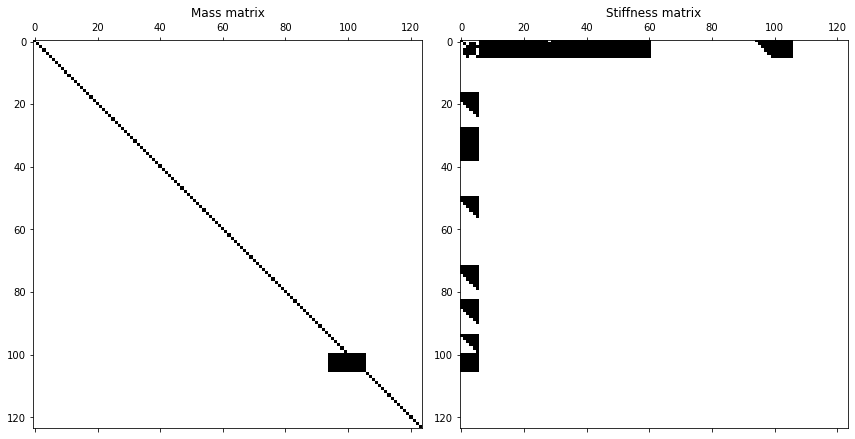

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax = axes[0]
ax.spy(M_val, precision=1e-12)
ax.set_title("Mass matrix")

ax = axes[1]
ax.spy(K_val, precision=1e-12)
ax.set_title("Stiffness matrix")

plt.tight_layout()
plt.show()

**Time portal to the future**: output matrices to file for future use

In [207]:
import os
import h5py

output_dir = "./out/matrices/Malkus/"
os.makedirs(output_dir, exist_ok=True)

with h5py.File(os.path.join(output_dir, "Mat_recipe-Daria_scipy.hdf5"), 'x') as f:
    f.attrs["Le"] = float(par_val[params.Le])
    f.attrs["Lu"] = "+inf"
    f.create_dataset("M", data=M_val)
    f.create_dataset("K", data=K_val)

## Eigenvalue solution

### Precomputed matrices

**Time portal from the past**: here we can choose to use previously computed matrices:

In [2]:
import h5py
with h5py.File("./out/matrices/Malkus/Mat_recipe-Daria.h5", 'r') as f:
    M_val = f["M"][()]
    K_val = f["K"][()]

# Also remember to load the configuration of the system (so that the solution can be reconstructed)
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import cfg_expand as cfg
from pg_utils.pg_model import params
from pg_utils.pg_model.expansion import omega, n, m, xi, n_test, n_trial
from pg_utils.numerics import matrices as nmatrix

map_trial = base.map_collection(cfg.bases_s, cfg.bases_s_expression.subs({n: n_trial}))
map_test = base.map_collection(cfg.test_s, cfg.bases_s_expression.subs({n: n_test}))

m_val = 3
azm_val = {m: m_val}
par_val = {params.Le: sympy.Rational(1, 10000), params.Lu: 1e+3}

# Build expansion range
Ntrunc = 5
fnames = base.CollectionPG.pg_field_names[:14]
cnames = cfg.coeff_s._field_names
ranges_trial = [np.arange(2*Ntrunc + 1) if 'M' in fname else np.arange(Ntrunc + 1) for fname in fnames]
ranges_test = [np.arange(2*Ntrunc + 1) if 'M' in fname else np.arange(Ntrunc + 1) for fname in fnames]

Check the condition number of the mass matrix.

If the condition number is too extreme for the mass matrix, inverting the mass matrix may not be a good idea. Note that it is always true that the mass matrix is invertible. Furthermore, the mass matrix usually has good diagonality or block diagonality, and the condition number is usually not that bad.

In [3]:
np.linalg.cond(M_val)

29202.379213476055

This would be problematic for regression problems, but still considered good for PDE-induced systems.

Now the problem can be recast to an ordinary eigenvalue problem.

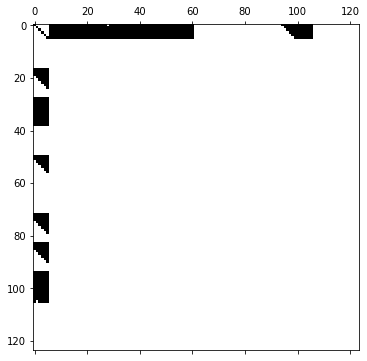

In [4]:
A_val = np.linalg.inv(M_val) @ K_val

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax = axes
ax.spy(A_val, precision=1e-14)
plt.show()

One can either further crop the matrix to exclude the trivial rows/columns to save some time, or one can simply plug the matrix into any ordinary eigenvalue solver.

Typically, given some reasonable size of the matrix, the eigen solver is not the bottleneck of the performance, and special treatment is not necessary. For instance, solving the ~$120\times 120$ matrix eigenvalue problem takes ~$4$ms.

In [5]:
eig_val, eig_vec = np.linalg.eig(A_val)

The output is further processed by sorting the eigenvalues according to their magnitudes

In [6]:
eig_sort = np.argsort(-np.abs(eig_val))
eig_val = eig_val[eig_sort]
eig_vec = eig_vec[:, eig_sort]

and splitting the eastwards and westwards modes (in the Malkus case this is the natural thing to do since we know the analytical solution).

In [7]:
eigidx_east = np.arange(eig_val.size)[np.imag(eig_val) < -1e-3]
eigidx_west = np.arange(eig_val.size)[np.imag(eig_val) > 1e-10]
eigv_east = eig_val[eigidx_east]
eigv_west = eig_val[eigidx_west]

**Time portal to the future**: output solution matrices to file for future use

In [214]:
import os
import h5py

output_dir = "./out/solutions/Malkus/"
os.makedirs(output_dir, exist_ok=True)

with h5py.File(os.path.join(output_dir, "Eigen_recipe-Daria_scipy.hdf5"), 'x') as f:
    f.attrs["Le"] = float(par_val[params.Le])
    f.attrs["Lu"] = "+inf"
    f.create_dataset("eigval", data=eig_val)
    f.create_dataset("eigvec", data=eig_vec)

### Precomputed eigenvalues
**Time portal from the past**: here we can choose to use previously computed eigensolutions:

In [2]:
import h5py

with h5py.File("./out/solutions/Malkus/Eigen_recipe-Daria.h5", 'r') as f:
    eig_val = f["eigval"][()]
    eig_vec = f["eigvec"][()]

eigidx_east = np.arange(eig_val.size)[np.imag(eig_val) < -1e-3]
eigidx_west = np.arange(eig_val.size)[np.imag(eig_val) > 1e-10]
eigv_east = eig_val[eigidx_east]
eigv_west = eig_val[eigidx_west]

# Also remember to load the configuration of the system (so that the solution can be reconstructed)
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import cfg_expand as cfg
from pg_utils.pg_model import params
from pg_utils.pg_model.expansion import omega, n, m, xi, n_test, n_trial
from pg_utils.numerics import matrices as nmatrix

map_trial = base.map_collection(cfg.bases_s, cfg.bases_s_expression.subs({n: n_trial}))
map_test = base.map_collection(cfg.test_s, cfg.bases_s_expression.subs({n: n_test}))

m_val = 3
azm_val = {m: m_val}
par_val = {params.Le: sympy.Rational(1, 10000), params.Lu: 1e+3}

# Build expansion range
Ntrunc = 5
fnames = base.CollectionPG.pg_field_names[:14]
cnames = cfg.coeff_s._field_names
ranges_trial = [np.arange(2*Ntrunc + 1) if 'M' in fname else np.arange(Ntrunc + 1) for fname in fnames]
ranges_test = [np.arange(2*Ntrunc + 1) if 'M' in fname else np.arange(Ntrunc + 1) for fname in fnames]

### Eigenvalues

In [3]:
eigv_east

array([0.00000000e+00-2352.94530137j, 2.01170325e-21-1165.05656736j,
       1.13686838e-13 -701.76750334j, 6.34762425e-15 -470.60762982j,
       8.54318023e-14 -338.05499417j, 9.81200134e-17 -254.81239972j])

### Eigenmodes

In [4]:
eigvec_east = eig_vec[:, eigidx_east]
eigvec_west = eig_vec[:, eigidx_west]

Assemble the expressions of the fields

In [5]:
field_func = base.LabeledCollection(
    cfg.recipe.rad_xpd.fields._field_names + ["us", "up", "uz"], 
    **{fname: (cfg.recipe.rad_xpd[fname]*cfg.recipe.fourier_xpd.bases.subs({t: 0})).subs(map_trial).subs(azm_val).subs({H: H_s}).doit()
       for fname in cfg.rad_expand.fields._field_names}
)
field_func.us = core.U_pg[0].subs({core.pgvar.Psi: field_func.Psi, H: H_s}).doit().simplify()
field_func.up = core.U_pg[1].subs({core.pgvar.Psi: field_func.Psi, H: H_s}).doit().simplify()
field_func.uz = core.U_pg[2].subs({core.pgvar.Psi: field_func.Psi, H: H_s}).doit().simplify()

field_func = field_func.apply(lambda expr: sympy.lambdify((s, p, z, n_trial, *[cf for cf in cfg.coeff_s]), expr, modules=["scipy", "numpy"]))

Choose one eigenmode to visualize and build the labeled eigenvector

In [6]:
mode, idx = "fast", 5
if mode == "fast":
    eigv, eigvec = eigv_east[idx], eigvec_east[:, idx]
elif mode == "slow":
    eigv, eigvec = eigv_west[idx], eigvec_west[:, idx]

eigvec = nmatrix.LabeledBlockArray(eigvec, fnames, 
    [2*Ntrunc + 1 if 'M' in fname else Ntrunc + 1 for fname in fnames])
eigvec = base.LabeledCollection(cfg.coeff_s._field_names, 
    **{cname: eigvec[cname] for cname in cnames})
map_coeff_vals = base.map_collection(cfg.coeff_s, eigvec)

### Visualization

In [7]:
field_nrange = {fname: ranges_trial[i_field] for i_field, fname in enumerate(fnames)}
field_nrange["us"] = field_nrange["Psi"]
field_nrange["up"] = field_nrange["Psi"]
field_nrange["uz"] = field_nrange["Psi"]

#### Radial plot

For radial plot, $\phi=Cst$, $z=Cst$.

In [8]:
p_cst = np.pi/4
z_cst = 0
s_array = np.linspace(0, 1, num=100)

Alternatively, one can use a list of s points corresponding to spacing in $\xi$

In [9]:
from scipy import special as specfun

xi_array, _ = specfun.roots_chebyt(100)
s_array = np.sqrt((1 + xi_array)/2)

Calculate all fields

In [10]:
def calc_field_rad(fname, field_f):
    S_mesh, N_mesh = np.meshgrid(s_array, field_nrange[fname], indexing='ij')
    eval_tmp = field_f(S_mesh, p_cst, z_cst, N_mesh, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot all fields

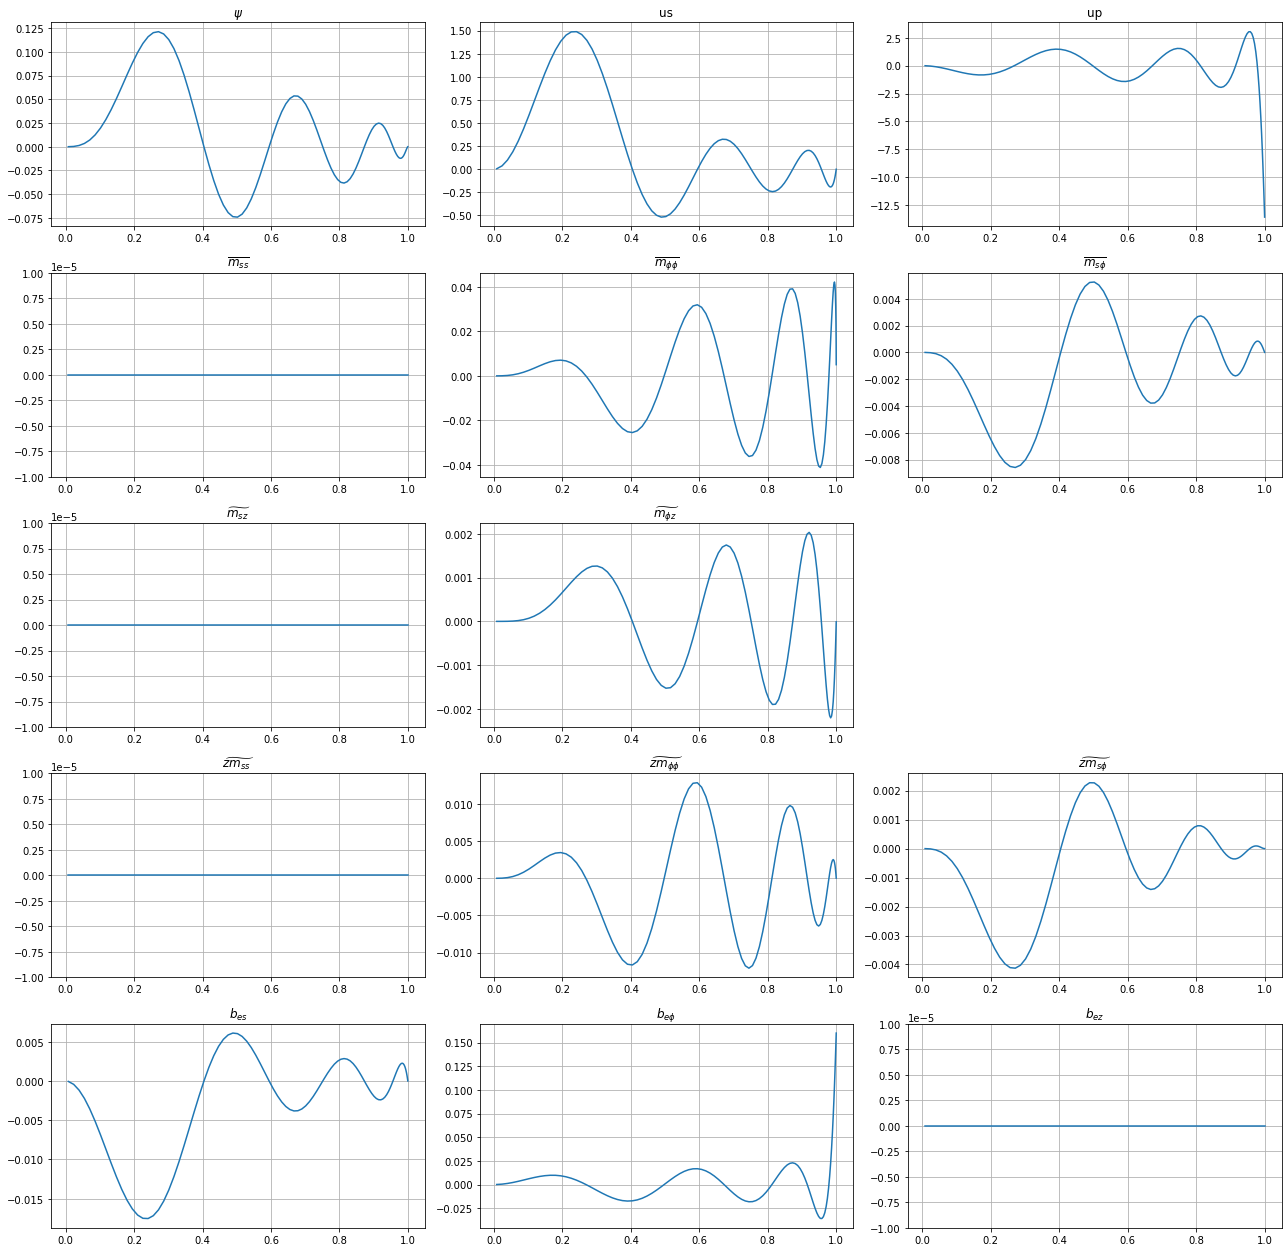

In [11]:
plot_fields = [["Psi", "us", "up"],
               ["Mss", "Mpp", "Msp"], 
               ["Msz", "Mpz", None], 
               ["zMss", "zMpp", "zMsp"], 
               ["Bs_e", "Bp_e", "Bz_e"]]

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*3.5))

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        ax.plot(s_array, np.real(eigmode_eval[fname]))
        if np.abs(np.real(eigmode_eval[fname])).max() < 1e-5:
            ax.set_ylim([-1e-5, +1e-5])
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar_ptb[fname].name,))
        else:
            ax.set_title(fname)
        ax.grid(True)

plt.tight_layout()
plt.show()

#### Equatorial plane plot

For Equatorial plane section, $z=0$. $s$ and $p$ form a mesh of grid points.

In [12]:
z_cst = 0
s_array = np.linspace(0, 1, num=100)
p_array = np.linspace(0, np.pi/2, num=100)
S_mesh, P_mesh = np.meshgrid(s_array, p_array)
X_mesh, Y_mesh = S_mesh*np.cos(P_mesh), S_mesh*np.sin(P_mesh)

Calculate all fields

In [13]:
def calc_field_rad(fname, field_f):
    N_trial = 2*Ntrunc + 1 if 'M' in fname else Ntrunc + 1
    S_tmp, P_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([P_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, z_cst, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot all fields

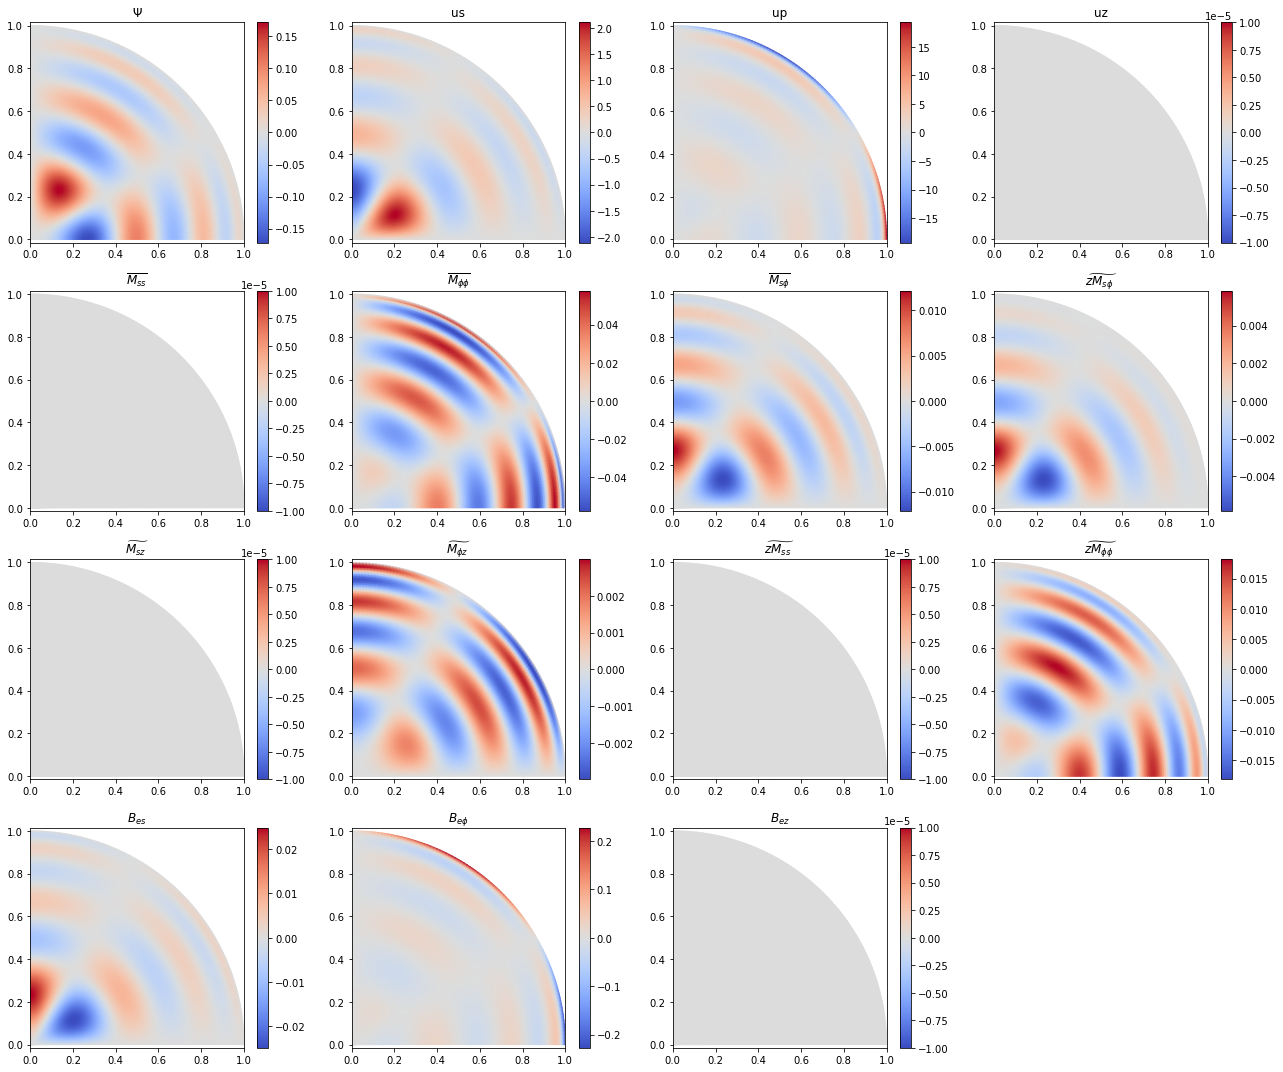

In [14]:
plot_fields = [["Psi", "us", "up", "uz"],
               ["Mss", "Mpp", "Msp", "zMsp"], 
               ["Msz", "Mpz", "zMss", "zMpp"], 
               ["Bs_e", "Bp_e", "Bz_e", None]]
save_name = None
# save_name = "./out/solutions/Malkus/m3n5_sympy_eqplot"
override = False

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.75))

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.abs(np.real(eigmode_eval[fname])).max() > 1e-5:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,))
        else:
            ax.set_title(fname)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

#### Meridional plane plot

For meridional plane section, $\phi=Cst$. $s$ and $z$ form a mesh of grid points.

In [15]:
p_cst = np.pi/4
r_array = np.linspace(0, 1, num=100)
theta_array = np.linspace(0, np.pi/2, num=100)
R_mesh, T_mesh = np.meshgrid(r_array, theta_array)
S_mesh, Z_mesh = R_mesh*np.sin(P_mesh), R_mesh*np.cos(P_mesh)

Calculate all fields

In [16]:
def calc_field_rad(fname, field_f):
    N_trial = 2*Ntrunc + 1 if 'M' in fname else Ntrunc + 1
    S_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, p_cst, Z_tmp, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot fields.

Note: physically, only plotting the fields defined in 3-D space make sense. Therefore, none of the PG variables have meridional plot, as all of the fields are defined in 2-D (most in the unit disk, $B_r$ on the surface of the sphere).

The only field with full volumetric definition is the velocity field, which of course takes the form of the ansatz.

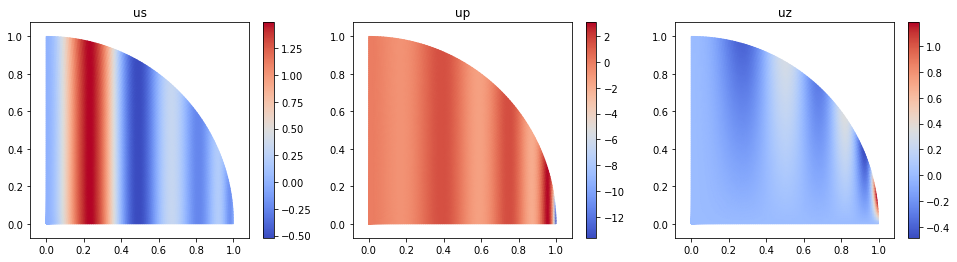

In [17]:
plot_fields = [["us", "up", "uz"],]
# save_name = "./out/solutions/Malkus/m3n5_sympy_mdplot"
save_name = None
override = False

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.75))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.real(eigmode_eval[fname]).max() > 1e-5:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,))
        else:
            ax.set_title(fname)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Comparison

1. In the Malkus case, the solution is indeed known in close form.

In [19]:
from pg_utils.numerics import utils as nutils
import pandas as pd

n_eigs = np.arange(1, 7)
omega_fast, omega_slow = nutils.eigenfreq_Malkus_pg(m_val, n_eigs, float(par_val[params.Le]), mode="all", timescale="alfven")

df_fast = pd.DataFrame({"Analytical": omega_fast, "PG": eigv_east/1j})
df_slow = pd.DataFrame({"Analytical": omega_slow, "PG": np.flip(eigv_west)/1j})

In [20]:
df_fast.transpose().style.format(formatter=lambda x: "{:.6e}".format(x))

,0,1,2,3,4,5
Analytical,-2.352945e+03+0.000000e+00j,-1.165057e+03+0.000000e+00j,-7.017675e+02+0.000000e+00j,-4.706077e+02+0.000000e+00j,-3.380551e+02+0.000000e+00j,-2.548127e+02+0.000000e+00j
PG,-2.352945e+03-0.000000e+00j,-1.165057e+03-2.011703e-21j,-7.017675e+02-1.136868e-13j,-4.706076e+02-6.347624e-15j,-3.380550e+02-8.543180e-14j,-2.548124e+02-9.812001e-17j


In [21]:
df_slow.transpose().style.format(formatter=lambda x: "{:.6e}".format(x))

,0,1,2,3,4,5
Analytical,4.124993e-03+0.000000e+00j,8.024945e-03+0.000000e+00j,1.312475e-02+0.000000e+00j,1.942420e-02+0.000000e+00j,2.692286e-02+0.000000e+00j,3.562002e-02+0.000000e+00j
PG,4.124898e-03-6.911751e-15j,8.023644e-03+1.027235e-14j,1.311719e-02+1.379692e-15j,1.939363e-02+8.174280e-15j,2.682231e-02+2.381068e-14j,3.533362e-02+1.056794e-14j


---
## Comparison with Mathematica result

This section compares the matrices and solutions obtained using the previous code by Daria in Mathematica.

For the time being, the two codes are not directly comparable, in that they do not offer the exact same ingredients.

Ingredients that are offered in `PleisoGeostroPy` but not in Code *Daria*:
- Flexible nondimensionalization: in `PlesioGeostroPy`, one can choose to assemble the forcing using rotation time scale or Alfven time scale; in Code *Daria*, only Alfven time scale.
- Flexible expansion: in `PlesioGeostroPy`, one can change expansion by using a different configuration file; in Code *Daria*, you need to rewrite the expansion.
Ingredients that are offered in Code *Daria* but not in `PlesioGeostroPy`:
- Magnetic diffusion, and in the most recent version also viscous diffusion and Ekman pumping

The following section compares a scenario where the two current codes both give full support:
- Malkus background field, zero background velocity
- Use Alfven time scale in `PlesioGeostroPy`: switch on the Alfven time scale in [Choose forcing](#Choose-forcing);
- Use a similar expansion in `PlesioGeostroPy` as in Code *Daria*. In fact, in order that the matrices are directly comparable, one can only use the form of expansion defined in Code *Daria* or Daria's thesis.
- Disable magnetic diffusion in Code *Daria*: set $\mathrm{Lu}=+\infty$;

First, read in the matrices assembled in Code *Daria*:

In [115]:
from scipy.io import mmread

M_mathematica = mmread("./out/M_mathematica.mtx")
K_mathematica = mmread("./out/K_mathematica.mtx")

Code *Daria* manually sets up the minimal size matrices. In contrast, in `PlesioGeostroPy`, once a set of equations have been selected (see [Select equations](#Select-Equations)), all relevant elements are collected to the matrices.

Direct comparison requires that the `PlesioGeostroPy` matrices are cropped similarly as Code *Daria*:

In [345]:
names_crop = ["Psi", "Mpp", "Msp", "Mpz", "zMpp", "zMsp", "Bs_e", "Bp_e"]
idx_crop = np.full(M_val.shape[0], False)
for name in names_crop:
    idx_crop[M_labeled._col_idx[name]] = True
crop_idx = np.arange(M_val.shape[0])[idx_crop]

M_crop = M_val[np.ix_(idx_crop, idx_crop)]
K_crop = K_val[np.ix_(idx_crop, idx_crop)]

### Matrix comparison

First the sparsity pattern of the matrices

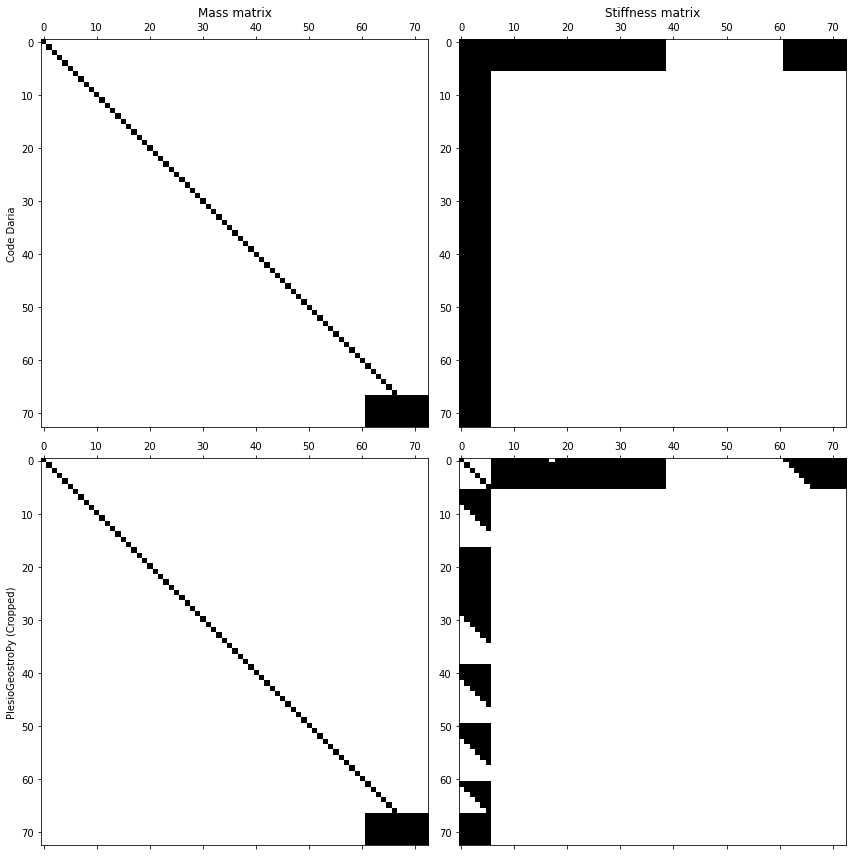

In [346]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax = axes[0, 0]
ax.spy(M_mathematica, precision=1e-15)
ax.set_ylabel("Code Daria")
ax.set_title("Mass matrix")
ax = axes[0, 1]
ax.spy(K_mathematica, precision=1e-15)
ax.set_title("Stiffness matrix")

ax = axes[1, 0]
ax.spy(M_crop, precision=1e-15)
ax.set_ylabel("PlesioGeostroPy (Cropped)")
ax = axes[1, 1]
ax.spy(K_crop, precision=1e-15)

plt.tight_layout()
plt.show()

Next, the values of the matrices are also compared.
This only makes sense if the **exact same expansions** are used in both codes.

In addition to that, note that in Code *Daria*, $\omega$ is the eigenvalue to be solved;
in `PlesioGeostroPy`, the eigenvalue is $\lambda = i\omega$.
Therefore, the matrices must be further converted to have the same format.

In [347]:
M_crop_mod = M_crop.copy()
M_crop_mod[6:, :] = M_crop_mod[6:, :]*1j

K_crop_mod = K_crop.copy()
K_crop_mod[:6, :] = K_crop_mod[:6, :]/1j

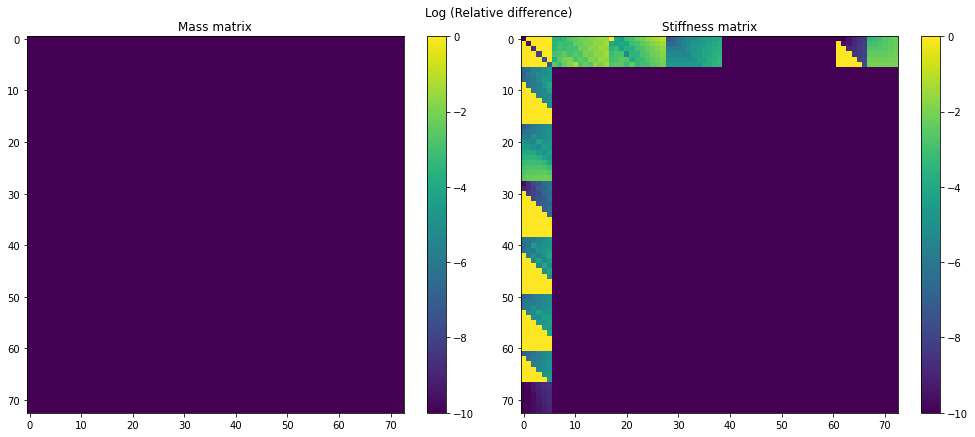

In [348]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax = axes[0]
divide = (np.abs(M_crop_mod) + np.abs(M_mathematica))/2
Mat_compare = 1e-20*np.ones_like(divide)
Mat_compare[divide > 1e-15] = np.abs(M_crop_mod - M_mathematica)[divide > 1e-15]/divide[divide > 1e-15] + 1e-20
cm = ax.imshow(np.log10(Mat_compare), vmin=-10, vmax=0)
plt.colorbar(cm, ax=ax)
ax.set_title("Mass matrix")

ax = axes[1]
divide = (np.abs(K_crop_mod) + np.abs(K_mathematica))/2
Mat_compare = 1e-20*np.ones_like(divide)
Mat_compare[divide > 1e-15] = np.abs(K_crop_mod - K_mathematica)[divide > 1e-15]/divide[divide > 1e-15] + 1e-20
cm = ax.imshow(np.log10(Mat_compare), vmin=-10, vmax=0)
plt.colorbar(cm, ax=ax)
ax.set_title("Stiffness matrix")

fig.suptitle("Log (Relative difference)")

plt.tight_layout()
plt.show()

### Eigenvalue solutions

Now we can calculate the eigenvalue solutions. For consistency, the solutions to be compared are from the matrices with the exact same configuration.

In [116]:
A_val = np.linalg.inv(M_mathematica) @ K_mathematica
eig_val_mathematica, eig_vec_mathematica = np.linalg.eig(A_val)
eig_sort = np.argsort(-np.abs(eig_val_mathematica))
eig_val_mathematica = eig_val_mathematica[eig_sort]
eig_vec_mathematica = eig_vec_mathematica[:, eig_sort]

eigidx_east = np.arange(eig_val_mathematica.size)[np.real(eig_val_mathematica) < -1]
eigidx_west = np.arange(eig_val_mathematica.size)[np.real(eig_val_mathematica) > 1e-3]
eig_mm_east = eig_val_mathematica[eigidx_east]
eig_mm_west = eig_val_mathematica[eigidx_west]

In [350]:
A_val = np.linalg.inv(M_crop_mod) @ K_crop_mod
eig_val_trial, eig_vec_trial = np.linalg.eig(A_val)
eig_sort = np.argsort(-np.abs(eig_val_trial))
eig_val_trial = eig_val_trial[eig_sort]
eig_vec_trial = eig_vec_trial[:, eig_sort]

eigidx_east = np.arange(eig_val_trial.size)[np.real(eig_val_trial) < -1]
eigidx_west = np.arange(eig_val_trial.size)[np.real(eig_val_trial) > 1e-3]
eig_py_east = eig_val_trial[eigidx_east]
eig_py_west = eig_val_trial[eigidx_west]

In [351]:
from pg_utils.numerics import utils as nutils
import pandas as pd

n_eigs = np.arange(1, 7)
omega_fast, omega_slow = nutils.eigenfreq_Malkus(m_val, n_eigs, float(par_val[params.Le]), mode="all", timescale="alfven")

df_fast = pd.DataFrame({"Analytical": omega_fast, "Code Daria": eig_mm_east, "PlesioGeostroPy": eig_py_east})
df_slow = pd.DataFrame({"Analytical": omega_slow, "Code Daria": np.flip(eig_mm_west), "PlesioGeostroPy": np.flip(eig_py_west)})

The fast modes

In [362]:
df_fast.transpose().style.format(formatter=lambda x: "{:.9e}".format(x))

,0,1,2,3,4,5
Analytical,-2.352945301e+03+0.000000000e+00j,-1.165056569e+03+0.000000000e+00j,-7.017675107e+02+0.000000000e+00j,-4.706076595e+02+0.000000000e+00j,-3.380550919e+02+0.000000000e+00j,-2.548126901e+02+0.000000000e+00j
Code Daria,-2.352945302e+03-1.202565825e-34j,-1.165056570e+03-4.186624679e-35j,-7.017675101e+02+3.049243624e-35j,-4.706076464e+02+5.118276780e-35j,-3.380550288e+02+2.117408035e-35j,-2.548124671e+02+2.406626434e-34j
PlesioGeostroPy,-2.352945301e+03+2.129106857e-45j,-1.165056567e+03-2.269720875e-46j,-7.017675033e+02+5.511116859e-45j,-4.706076298e+02+1.428422844e-45j,-3.380549942e+02-2.227237721e-45j,-2.548123997e+02+8.549738768e-45j


The slow modes

In [360]:
df_slow.transpose().style.format(formatter=lambda x: "{:.6e}".format(x))

,0,1,2,3,4,5
Analytical,4.124993e-03+0.000000e+00j,8.024945e-03+0.000000e+00j,1.312475e-02+0.000000e+00j,1.942420e-02+0.000000e+00j,2.692286e-02+0.000000e+00j,3.562002e-02+0.000000e+00j
Code Daria,4.125273e-03-6.502579e-33j,8.025441e-03+3.072530e-31j,1.312252e-02-4.963987e-31j,1.940629e-02+2.580917e-31j,2.684780e-02-8.716713e-32j,3.537884e-02+1.762715e-32j
PlesioGeostroPy,4.124898e-03-9.574992e-44j,8.023644e-03-1.084026e-41j,1.311719e-02+1.619079e-41j,1.939363e-02-1.093123e-41j,2.682231e-02+3.478229e-42j,3.533362e-02-6.323255e-43j


In [117]:
import os
import h5py

output_dir = "./out/solutions/Malkus/"
os.makedirs(output_dir, exist_ok=True)

with h5py.File(os.path.join(output_dir, "Eigen_recipe-Daria_mm.hdf5"), 'x') as f:
    f.attrs["Le"] = float(par_val[params.Le])
    f.attrs["Lu"] = "+inf"
    f.create_dataset("eigval", data=eig_val_mathematica)
    f.create_dataset("eigvec", data=eig_vec_mathematica)